In [ ]:
from sentence_transformers import SentenceTransformer, util

embedder = SentenceTransformer("intfloat/multilingual-e5-small")
# embedder = SentenceTransformer("BAAI/bge-m3")
# embedder = SentenceTransformer("all-MiniLM-L6-v2")

embedding1 = embedder.encode("สำนักงานเทศบาลตำบลบ่อทอง", convert_to_tensor=True)
embedding2 = embedder.encode("สำนักงานเทศบาลตำบลโคกโพธิ์", convert_to_tensor=True)

print("Cosine similarity:", util.cos_sim(embedding1, embedding2))


In [ ]:
embedding1

In [ ]:
!ls ~/.cache/huggingface/hub 

In [ ]:
import pandas as pd

df = pd.read_csv("gis_data/GIS_L_202507.csv", sep="|", header=None, dtype=str, encoding="utf-8")
columns = [
    "pea_number", 
    "ca_number", 
    "lat", 
    "long", 
    "route_code", 
    "office_code", 
    "billing_date", 
    "read_unit", 
    "billing_month", 
    "customer_name", 
    "customer_address"
]

df.columns = columns[:df.shape[1]]


In [ ]:
df

In [ ]:
df_dropped = df.dropna()
df_cleaned = df_dropped.drop_duplicates(subset="ca_number", keep="first").copy()  # <- add .copy()

# --- Trim all string columns ---
for col in df_cleaned.select_dtypes(include="object").columns:
    df_cleaned[col] = df_cleaned[col].str.strip()

In [ ]:
df_cleaned

In [ ]:
from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer("BAAI/bge-m3")  # outputs 1024-dim embeddings
embedder = SentenceTransformer("intfloat/multilingual-e5-small")

In [1]:
import psycopg2

conn = psycopg2.connect(
    dbname="rag-pea",
    user="leocan",
    password="leocanza",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

In [ ]:
# --- Create table (only run once) ---
cur.execute("""
CREATE TABLE IF NOT EXISTS gis_vector (
    ca_number        TEXT PRIMARY KEY,
    pea_number       TEXT,
    customer_name    TEXT,
    customer_address TEXT,
    office_code      TEXT,
    lat              DOUBLE PRECISION,
    long             DOUBLE PRECISION,
    billing_month    TEXT,
    embedding        VECTOR(384)
);
""")

conn.commit()

In [ ]:
for i, row in df_cleaned.iterrows():
    # Embedding from customer_name
    name_text = row["customer_name"] if pd.notna(row["customer_name"]) else ""
    embedding = embedder.encode(name_text).tolist()
    # print(row["customer_name"], embedding[:100])

    cur.execute("""
        INSERT INTO gis_vector
        (ca_number, pea_number, customer_name, customer_address, office_code, lat, long, billing_month, embedding)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        ON CONFLICT (ca_number) DO UPDATE
        SET pea_number       = EXCLUDED.pea_number,
            customer_name    = EXCLUDED.customer_name,
            customer_address = EXCLUDED.customer_address,
            office_code      = EXCLUDED.office_code,
            lat              = EXCLUDED.lat,
            long             = EXCLUDED.long,
            billing_month    = EXCLUDED.billing_month,
            embedding        = EXCLUDED.embedding;
    """, (
        row["ca_number"],
        row["pea_number"], 
        row["customer_name"],
        row["customer_address"],
        row["office_code"],
        row["lat"], 
        row["long"],
        row["billing_month"],
        embedding
    ))

    print("done row: ", i)

    # if i > 100:  # only insert first 10 rows for testing
    #     break


conn.commit()
cur.close()
conn.close()

In [32]:
from sentence_transformers import SentenceTransformer
import psycopg2

embedder = SentenceTransformer("intfloat/multilingual-e5-small")

query_text = "นาย เอกพงศ์ คงสวัสดิ์"
query_embedding = embedder.encode(query_text).tolist()

conn = psycopg2.connect(
    dbname="rag-pea",
    user="leocan",
    password="leocanza",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

cur.execute("""
    SELECT ca_number, pea_number, customer_name, customer_address, office_code, lat, long, billing_month,
            1 - (embedding <=> %s::vector) AS similarity_score
    FROM gis_vector
    ORDER BY similarity_score DESC
    LIMIT 10;
""", (query_embedding,))

results = cur.fetchall()
for row in results:
    print(row)

cur.close()
conn.close()

('020022082715', '6000287747', 'นาย เอกพงศ์ คล้ายคง', '790/58 สุขสำราญ ม.3 ต.พะวง อ.เมืองสงขลา จ.สงขลา 90', 'LSKL', 7.10461671, 100.5755389, '202507', 0.9519761800766262)
('020007149984', '6200429479', 'นาย เอกพงษ์ คงรอด', '196 ม.8 ต.ชะรัด อ.กงหรา จ.พัทลุง 93000', 'LPTL', 7.46581047, 99.97353126, '202507', 0.9496146440506251)
('020007763722', '5800935303', 'นาย คง ศรีสวัสดิ์', '22 หมู่ 4 ม.4 ต.ทุ่งหวัง อ.เมืองสงขลา จ.สงขลา 9000', 'LSKL', 7.05644999, 100.63576166, '202507', 0.9484522090746083)
('020007494375', '20164586', 'นาย คง ศรีสวัสดิ์', '262 ถ.ยนตรการกำธร ม.4 ต.เกตรี อ.เมืองสตูล จ.สตูล 9', 'LSAT', 6.67742072, 100.07881035, '202507', 0.9484522090746083)
('020021719162', '6000641939', 'นาย ประเสริฐ คงสวัสดิ์', 'เกษตรกรรม(42/2 ม.1 ต.วัดจันทร์) ม.1 ต.วัดจันทร์ อ.', 'LSTP', 7.39238038, 100.46565866, '202507', 0.9470753764375388)
('020008019343', '5600653586', 'นาย ประเสริฐ คงสวัสดิ์', '42/2 บ.บ่อประดู่ ม.1 ต.วัดจันทร์ อ.สทิงพระ จ.สงขลา', 'LSTP', 7.39253911, 100.46921353, '202507', 0.94

In [31]:
# fuzzy match using pg_trgm
# ใช้ pg_trgm (Trigram search) 🔥 (แนะนำ) ติดตั้ง extension ก่อน (ทำครั้งเดียวใน DB):
# CREATE EXTENSION IF NOT EXISTS pg_trgm;
import psycopg2

query_text = "อรุณ คงสวัส"

conn = psycopg2.connect(
    dbname="rag-pea",
    user="leocan",
    password="leocanza",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

# set similarity threshold ให้ต่ำลง
# cur.execute("CREATE EXTENSION IF NOT EXISTS pg_trgm;")
cur.execute("SET pg_trgm.similarity_threshold = 0.5;")

cur.execute("""
    SELECT ca_number, pea_number, customer_name, customer_address, office_code, lat, long, billing_month,
           similarity(customer_name, %s) AS sim
    FROM gis_vector
    WHERE customer_name %% %s
    ORDER BY sim DESC
    LIMIT 1;
""", (query_text, query_text))

results = cur.fetchall()
for row in results:
    print(row)

cur.close()
conn.close()

('020008076556', '21539803', 'นาย อรุณ คงสวัสดิ์', '44 บ.โคกโก ม.4 ต.ลำภู อ.เมืองนราธิวาส จ.นราธิวาส 9', 'LNTW', 6.35648316, 101.80313811, '202507', 0.57894737)


In [8]:
results

[]

In [38]:
import psycopg2

conn = psycopg2.connect(
    dbname="rag-pea",
    user="leocan",
    password="leocanza",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

cur.execute("""
    SELECT embedding
    FROM gis_vector
    LIMIT 10;
""")

results = cur.fetchall()

cur.close()
conn.close()


In [10]:
from sentence_transformers import SentenceTransformer
import psycopg2

embedder = SentenceTransformer("intfloat/multilingual-e5-small")

query_text = "นาย เอกพงศ์ คงสวัสดิ์"
query_embedding = embedder.encode(query_text).tolist()

conn = psycopg2.connect(
    dbname="rag-pea",
    user="leocan",
    password="leocanza",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

cur.execute("""
    SELECT embedding,
            1 - (embedding <=> %s::vector) AS similarity_score,
            customer_name
    FROM gis_vector
    ORDER BY similarity_score DESC
    LIMIT 1000;
""", (query_embedding,))

results = cur.fetchall()
cur.close()
conn.close()

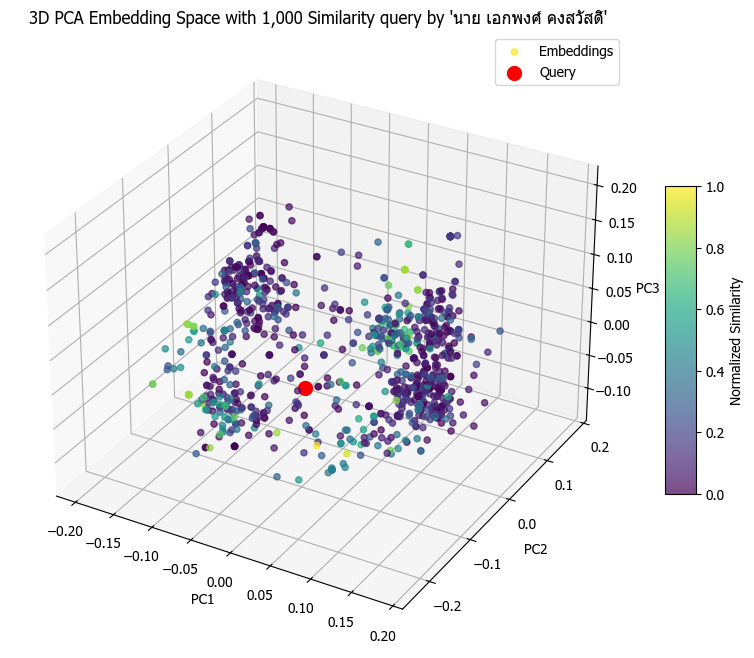

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert vector string to float list
embeddings = [np.array(ast.literal_eval(row[0])) for row in results]
similarities = [row[1] for row in results]  # similarity scores from DB

# Combine with query embedding
all_embeddings = np.vstack([embeddings, query_embedding])

# Reduce to 3D
pca = PCA(n_components=3)
reduced = pca.fit_transform(all_embeddings)

# Split back
reduced_embeddings = reduced[:-1]
reduced_query = reduced[-1]

# Normalize similarity for coloring
similarities = np.array(similarities)
norm = (similarities - similarities.min()) / (similarities.max() - similarities.min())

# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Embeddings colored by similarity
scatter = ax.scatter(
    reduced_embeddings[:,0],
    reduced_embeddings[:,1],
    reduced_embeddings[:,2],
    c=norm,               # color by similarity
    cmap="viridis",       # or "hot", "coolwarm"
    alpha=0.7,
    label="Embeddings"
)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Normalized Similarity")

# Query point
ax.scatter(
    reduced_query[0],
    reduced_query[1],
    reduced_query[2],
    color="red",
    s=100,
    label="Query"
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Embedding Space with 1,000 Similarity query by 'นาย เอกพงศ์ คงสวัสดิ์'")
ax.legend()
plt.show()

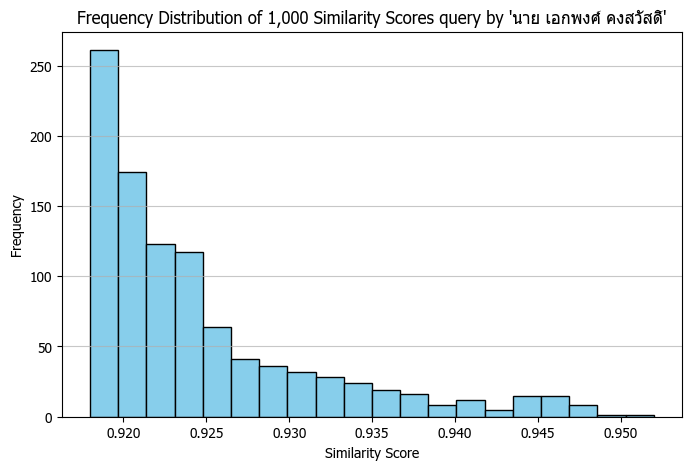

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extract similarity scores
similarities = [row[1] for row in results]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of 1,000 Similarity Scores query by 'นาย เอกพงศ์ คงสวัสดิ์'")
plt.grid(axis='y', alpha=0.7)
plt.show()

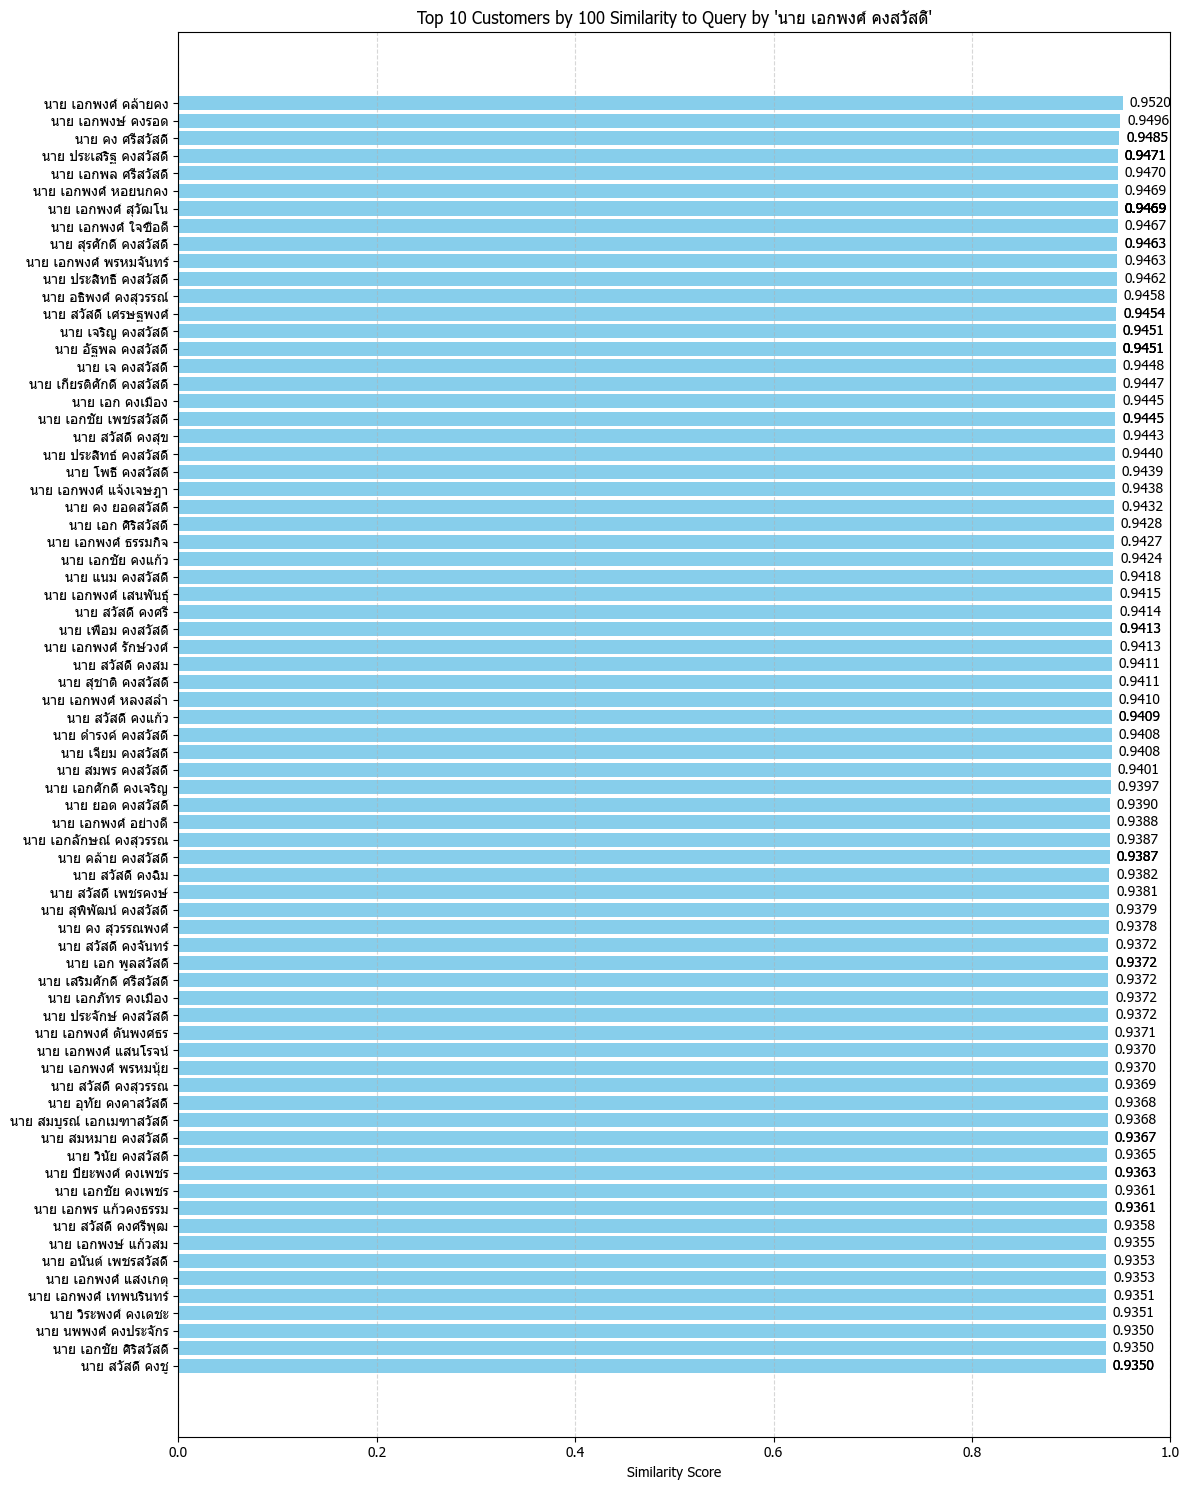

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set a Thai-compatible font
rcParams['font.family'] = 'Tahoma'  # or 'Noto Sans Thai' if installed

# Extract top 10 customer names and similarity scores
top_results = results[:100]
customer_names = [row[2] for row in top_results]  # customer_name
similarity_scores = [row[1] for row in top_results]

# Horizontal bar chart
plt.figure(figsize=(12, 15))
bars = plt.barh(customer_names[::-1], similarity_scores[::-1], color='skyblue')
plt.xlabel("Similarity Score")
plt.title("Top 100 Customers by 1,000 Similarity to Query by 'นาย เอกพงศ์ คงสวัสดิ์'")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.bar_label(bars, fmt='%.4f', padding=5)
plt.tight_layout()
plt.show()